In [1]:
import os, sys, torch, argparse, re, mat73, scipy, time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurokit2 as nk

from copy import deepcopy
import pandas as pd
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from LibMTL.config import LibMTL_args, prepare_args
from LibMTL.utils import set_random_seed, set_device
from LibMTL.model import resnet_dilated
from LibMTL import Trainer
from Projects.radarODE_plus.utils.utils import shapeMetric, shapeLoss, ppiMetric, ppiLoss, anchorMetric, anchorLoss
from Projects.radarODE_plus.nets.PPI_decoder import PPI_decoder
from Projects.radarODE_plus.nets.anchor_decoder import anchor_decoder
from Projects.radarODE_plus.nets.model import backbone, shapeDecoder, ECGFormer
from config import prepare_args
from Projects.radarODE_plus.spectrum_dataset import normal_ecg_torch_01
from spectrum_dataset import dataset_concat
%matplotlib inline
data_org_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_org/"
rcg_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_rcg/test"
sst_root = '/home/zhangyuanyuan/Dataset/data_MMECG/30Hz_half/'
interval_root = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/'
pred_all_root = '/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/'
params, unknown = LibMTL_args.parse_known_args()
params.mode = 'test'
params.gpu_id = '1'
set_device(params.gpu_id)

In [2]:

def norm_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def norm_ecg_11(ECG):
    k=2/(np.max(ECG)-np.min(ECG))
    ECG = -1+k*(ECG-np.min(ECG))
    return ECG
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def cross_entropy_loss_ppi(ecg_rcon, ecg_gts):
    # the max/min ppi is 252/97, so we can use 155 as the range
    # count how many -1 are there in each batch of ecg_gts
    ecg_rcon, ecg_gts = ecg_rcon.squeeze(1), ecg_gts.squeeze(1)
    counts = ecg_gts.size(1)-(ecg_gts == -10).sum(dim=1)
    batch_indices = torch.arange(ecg_gts.size(0))
    ecg_gts = torch.zeros_like(ecg_gts)
    ecg_gts[batch_indices, counts-1] = 10
    loss = nn.CrossEntropyLoss()
    possi = ecg_gts.softmax(dim=1)
    # return loss(ecg_rcon, possi)
    return ecg_gts, loss(ecg_rcon, possi)
# normlizaiton to [0,1]
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def down_sample(ecg, target_len=200):
    # using numpy
    ecg=np.interp(np.linspace(0, len(ecg), target_len), np.arange(len(ecg)), ecg)
    return ecg
def load_sst(sst_path):
    """
    load sst result generated from matlab
    """
    sst_plot = mat73.loadmat(sst_path, use_attrdict=True)
    # sst_plot = scipy.io.loadmat(sst_path, use_attrdict=True)
    sst_plot = np.flip(sst_plot['SST'], 1)
    return sst_plot
def mat2df(ID_in):
    """
    Read .mat file from original MMECG dataset to a pandas dataframe.
    """
    # ID is the index of data files, Obj_ID is the index for actual person under test
    columnnames = ['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ',
                   'gender', 'age', 'physistatus']
    df = pd.DataFrame(columns=columnnames)
    df.loc[0, columnnames] = [1, 2, 3, 4, 5, 6, 7, 8]

    for ID in range(1, 92):
        ID = ID_in
        data = scipy.io.loadmat(data_org_root+str(ID)+'.mat')
        Obj_ID = data['data'][0]['id']
        RCG = np.array([i for i in data['data'][0]['RCG']]
                       ).squeeze().transpose()
        ECG = np.array([i for i in data['data'][0]['ECG']]).squeeze()
        posXYZ = np.array([i for i in data['data'][0]['posXYZ']]).squeeze()
        gender = data['data'][0]['gender'].squeeze()
        age = data['data'][0]['age'].squeeze()
        physistatus = data['data'][0]['physistatus'].squeeze()

        df.loc[ID-1, columnnames] = [ID, int(Obj_ID), RCG,
                                     ECG, posXYZ, gender, int(age), physistatus]
        break
    return df
def smooth2nd(x,M): ##x 为一维数组
    K = round(M/2-0.1) ##M应为奇数，如果是偶数，则取大1的奇数
    lenX = len(x)
    if lenX<2*K+1:
        print('数据长度小于平滑点数')
    else:
        y = np.zeros(lenX)
        for NN in range(0,lenX,1):
            startInd = max([0,NN-K])
            endInd = min(NN+K+1,lenX)
            y[NN] = np.mean(x[startInd:endInd])
##    y[0]=x[0]       #首部保持一致
##    y[-1]=x[-1]     #尾部也保持一致
    return(y)
def index_convert(index, freq_org=200, freq_desired=30):
    """
    :param index: the index of the signal with freq=freq_org
    :param freq_org: the original freq of the signal
    :param freq_desired: the desired freq of the signal
    :return: the index of the signal with freq=freq_desired
    """
    return int(index * freq_desired / freq_org)
def offset_cal(pred, gts, os_range = 3000):
    offsets = np.arange(0, 41)-20
    error_min = 1000
    for offset in offsets:
        pred_plot = norm_ecg(pred[os_range+offset:-os_range+offset])
        gts_plot = norm_ecg(gts[os_range:-os_range])
        rmse = np.sqrt(mean_squared_error(pred_plot, gts_plot))
        if rmse < error_min:
            error_min = rmse
            offset_min = offset
    return offset_min

In [3]:
obj_index = 80
obj_index = 1
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_200/'
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_ecg/'
params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle/'
# params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_pulse/'
# params.dataset_path = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/'
params.save_path = '/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/'
# state_dict_path = f'/home/zhangyuanyuan/radarODE_plus/Model_saved/best_model_cross_vali_{(obj_index-9)//8+1}_ce_.pth'
set_random_seed(params.seed)
params.test_bs = 1
params.aug_snr = 100
params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt' # best for training with step dataset
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_1.pt' # best for EGA, weight for task 1 = 5
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_10_save.pt'

# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EW.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Given_weight_3.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_test.pt'
# # params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_mean.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_5.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_UW.pt' 
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EW_3.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_new.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/cur_UW_ode.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_MoCo.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_IMTL.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_DB_MTL.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_PCGrad.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_GradDrop.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_RLW.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_GradVac.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_CAGrad.pt'

params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_DWA.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_RLW.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_IMTL.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_MGDA.pt'
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_MGDA.pt' 

# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/step/best_UW.pt' # best one

# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/middle/best_UW_ecg.pt' # good one
# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/test/best_UW.pt' 

# params.load_path='/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Given_weight.pt'

# define tasks
task_dict = {'ECG_shape': {'metrics': ['MSE', 'CE', 'norm_MSE'],
                            'metrics_fn': shapeMetric(),
                            'loss_fn': shapeLoss(),
                            'weight': [0, 0, 0]},
                'PPI': {'metrics': ['CE', 'PPI_sec'],
                        'metrics_fn': ppiMetric(),
                        'loss_fn': ppiLoss(),
                        'weight': [0, 0]},
                'Anchor': {'metrics': ['mse'],
                        'metrics_fn': anchorMetric(),
                        'loss_fn': anchorLoss(),
                        'weight': [0]}}

In [4]:
radarODE_test_set = dataset_concat(ID_selected=np.array([obj_index]), data_root=params.dataset_path, aug_snr = params.aug_snr)
testloader = torch.utils.data.DataLoader(dataset=radarODE_test_set, batch_size=params.test_bs, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

In [5]:
kwargs, optim_param, scheduler_param = prepare_args(params)
# # define backbone and en/decoders
def encoder_class(): 
    return backbone(in_channels=50)
num_out_channels = {'PPI': 260, 'Anchor': 200}
decoders = nn.ModuleDict({'ECG_shape': shapeDecoder(),
                            'PPI': PPI_decoder(output_dim=num_out_channels['PPI']),
                            # 'Anchor': PPI_decoder(output_dim=num_out_channels['Anchor'])})
                            'Anchor': anchor_decoder()})

class radarODE_plus(Trainer):
    def __init__(self, task_dict, weighting, architecture, encoder_class,
                    decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
        super(radarODE_plus, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, modelName=f'{weighting}', **kwargs)


radarODE_plus_model = radarODE_plus(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders, 
rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param, save_path=params.save_path, load_path=params.load_path, **kwargs)

Inputs, Preds, Gts, Losses, improvement = radarODE_plus_model.test_visiual(testloader)

General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/
	Load Path: /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
	Device: cuda:1
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_STCH.pt
Total Params: 37712961
Trainable Params: 37712961
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | PPI_LOSS CE PPI_sec | Anchor_LOSS mse | TIME


100%|██████████| 198/198 [00:08<00:00, 24.49it/s]

TEST: 0.0049 0.0057 0.0049 5.2793 | 2.1626 0.0164 2.1626 | 0.0070 62.1806 | Time: 8.0980



In [6]:
ECG_gts, ECG_pred = [], []
PPI_gts, PPI_pred = [], []
Anchor_gts, Anchor_pred =[], []
ssts, masks = [], []
losses_ppi, losses_mse, losses_anchor, losses_mtl = [], [], [], []
for i in range(len(Preds)):
    ECG_gts.append(Gts[i]['ECG_shape'].detach().cpu().numpy().squeeze())
    ECG_pred.append(Preds[i]['ECG_shape'].detach().cpu().numpy().squeeze())
    PPI_gts.append(Gts[i]['PPI'].detach().cpu().numpy().squeeze())
    PPI_pred.append(Preds[i]['PPI'].detach().cpu().numpy().squeeze())
    mask, loss_ppi = cross_entropy_loss_ppi(Preds[i]['PPI'], Gts[i]['PPI'])
    Anchor_gts.append(Gts[i]['Anchor'].detach().cpu().numpy().squeeze())
    Anchor_pred.append(Preds[i]['Anchor'].detach().cpu().numpy().squeeze())
    masks.append(mask.detach().cpu().numpy().astype(float).squeeze())
    ssts.append(Inputs[i][0].detach().cpu().numpy().astype(float))
    losses_mse.append(Losses[i][0].item())
    losses_ppi.append(loss_ppi.item())
    losses_anchor.append(Losses[i][2].item())

ssts = np.array(ssts)
ECG_gts, ECG_pred, PPI_gts, PPI_pred, Anchor_gts, Anchor_pred = np.array(ECG_gts), np.array(ECG_pred), np.array(PPI_gts), np.array(PPI_pred), np.array(Anchor_gts), np.array(Anchor_pred)
masks = np.array(masks)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2024-08-09 10:15:43


In [7]:
df = mat2df(obj_index)

In [8]:
directory = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/"
directory = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/"
peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"
ecg_seg_index_root = "/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/"
seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))
def des_path_finder(index,path):
    for roots, dirs, files in os.walk(path):
        for dir_ in dirs:
            if re.search(f'_{index}_', dir_):
                return roots, dir_
def sst_finder(index, path):
    for file in os.listdir(path):
        if re.search(f'_{index}_', file):
            return file

cur_root, cur_dir = des_path_finder(obj_index, directory)
obj_path=os.path.join(cur_root, cur_dir)
sst_path = os.path.join(sst_root, sst_finder(obj_index, sst_root))
interval_path_median = os.path.join(interval_root, f'{obj_index}_median.npy')
interval_path_kde_nosample = os.path.join(interval_root, f'{obj_index}_kde_nosample.npy')
interval_path_kde = os.path.join(interval_root, f'{obj_index}_kde.npy')
interval_path_gts = os.path.join(interval_root, f'{obj_index}_gts.npy')
pred_ecg_obj_path = os.path.join(pred_all_root, f'{obj_index}.npy')
ecg_seg_index_path = os.path.join(ecg_seg_index_root, f'ecg_seg_index_{obj_index}.csv')
obj_path, sst_path, interval_path_kde_nosample, interval_path_gts, ecg_seg_index_path

('/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj1_NB_1_',
 '/home/zhangyuanyuan/Dataset/data_MMECG/30Hz_half/SST_obj1_NB_1_30Hz.mat',
 '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/1_kde_nosample.npy',
 '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/1_gts.npy',
 '/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/ecg_seg_index_1.csv')

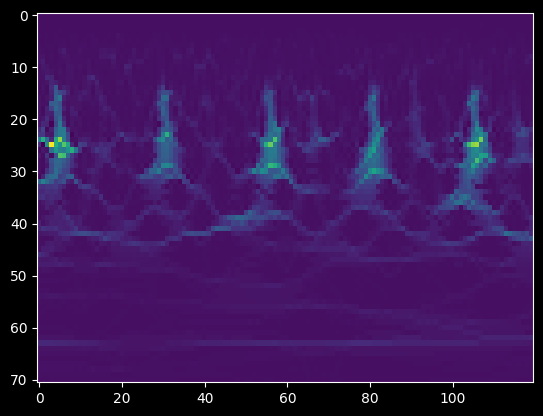

In [9]:
sst_plot = ssts[18][13]
plt.imshow(sst_plot, aspect='auto')

### PPI eval

(169, 171)

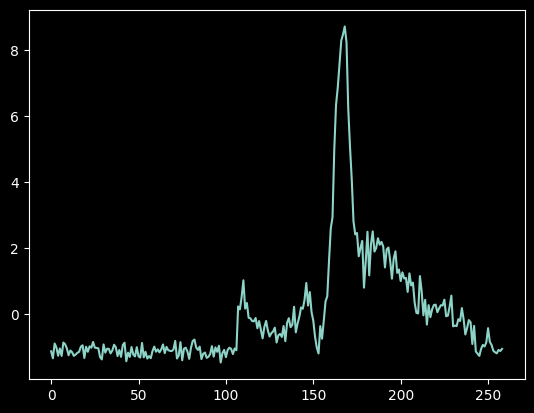

In [10]:
rank_ppi = np.argsort(losses_ppi)
i = rank_ppi[-10]    
# i = 10
pred = PPI_pred[i]
index_pred = np.where(pred==np.max(pred))[0][0]+1
gts = PPI_gts[i]
index_gts = 260-len(np.where(gts == -10)[0])
mask_gts = masks[i]
end=259
# plt.plot(gts[:end])
plt.plot(pred[:end])
# plt.plot(mask_gts[:end])
plt.style.use('default')
index_pred, index_gts

In [11]:
kde_path = f'/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/{obj_index}_kde.npy'
# kde_path = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/14_gts.npy'
kde = np.load(kde_path)

0.013912606012555881

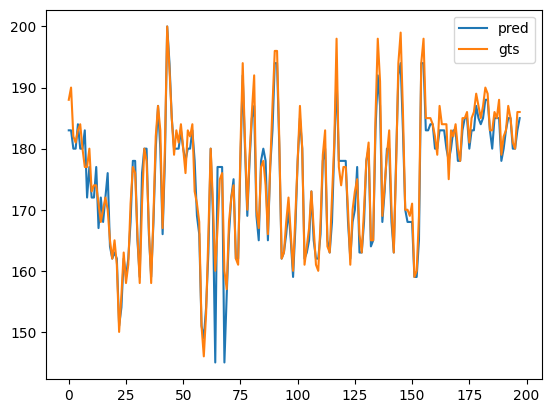

In [12]:
ppi_pred = np.argmax(np.array(PPI_pred), axis=1)
ppi_gts = np.argmax(np.array(masks), axis=1)
# np.save('ppi_gts.npy', ppi_gts)
# np.save('ppi_pred.npy', ppi_pred)
plt.plot((ppi_pred), label='pred')
plt.plot((ppi_gts), label='gts')
# plt.plot(down_sample(kde), label='kde')
plt.legend()
# rmse
ppi_rmse = np.sqrt(mean_squared_error(ppi_gts, ppi_pred))/200
ppi_rmse

### ECG shape eval

0.7743050048698732
MSE: 0.005788774803432342
RMSE: 0.07608399834020517
Pearson correlation coefficient 0.8713327679341902


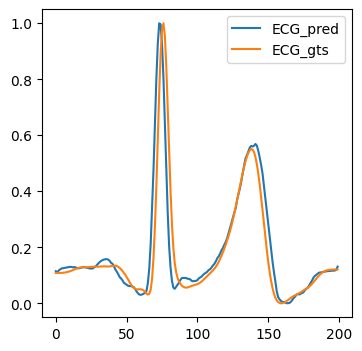

In [13]:
rank_mse = np.argsort(losses_mse)
index=rank_mse[-20]   
index_rcg=20
ecg_gts=ECG_gts[index]
ecg_gts = down_sample(ecg_gts, 200)
ecg_pred=ECG_pred[index]
plt.figure(figsize=(4,4))
plt.plot(norm_ecg(ecg_pred), label='ECG_pred')
plt.plot(norm_ecg(down_sample(ecg_gts,200)), label='ECG_gts')
plt.legend()
plt.style.use('default')
k=1/(np.max(ecg_gts)-np.min(ecg_gts))
mse=mean_squared_error(norm_ecg(ecg_gts)/k, norm_ecg(ecg_pred)/k)
print((np.max(ecg_gts)-np.min(ecg_gts)))
print("MSE:",mse)
print("RMSE:",np.sqrt(mse))
print('Pearson correlation coefficient', np.corrcoef(ecg_gts, ecg_pred)[0,1])

In [14]:
# calculate rmse error for data
ecg_shape_rmse = np.array([])
mses = np.array([])
cors = np.array([])
for i in range(0, len(ECG_gts)):
    ecg_gts=ECG_gts[i]
    ecg_gts=down_sample(ecg_gts, 200)
    ecg_pred=ECG_pred[i][:200]
    factor = 1/(np.max(ecg_gts)-np.min(ecg_gts))
    ecg_min = np.min(ecg_gts)
    ecg_gts = norm_ecg(ecg_gts)
    ecg_pred = norm_ecg(ecg_pred)
    mse=mean_squared_error(ecg_gts/factor, ecg_pred/factor)
    mses = np.append(mses, (mse))
    ecg_shape_rmse = np.append(ecg_shape_rmse, np.sqrt(mse))
    cor = np.corrcoef(ecg_gts, ecg_pred)[0,1]
    cors = np.append(cors, cor)
print("RMSE Mean:",np.mean(ecg_shape_rmse),"Median:",np.median(ecg_shape_rmse), "Cor", np.mean(cors))

RMSE Mean: 0.053354699414516545 Median: 0.04496656780369151 Cor 0.9361319363676208


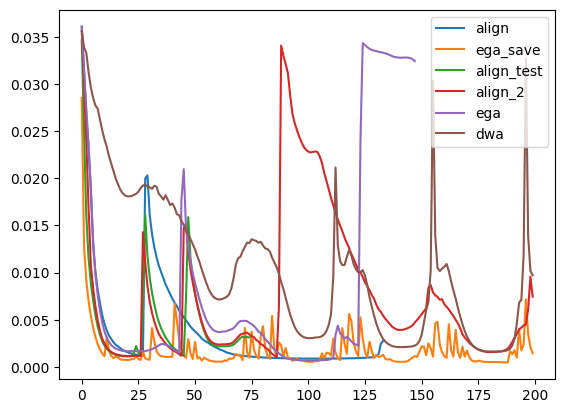

In [15]:
task = 0
flag = 'train'
# flag = 'test'
ega_save = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_10_{flag}_save.npy')[task]
align = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_{flag}.npy')[task]
align_test = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_test_{flag}.npy')[task]
align_2 = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_2_{flag}.npy')[task]
dwa = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_DWA_{flag}.npy')[task]
ega = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_{flag}.npy')[task]
uw = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_UW_{flag}.npy')[task]
plt.plot(align[align!=0], label='align')
plt.plot(ega_save[ega_save!=0], label='ega_save')
plt.plot(align_test[align_test!=0], label='align_test')
plt.plot(align_2[align_2!=0], label='align_2')
plt.plot(ega[ega!=0], label='ega')
plt.plot(dwa[dwa!=0], label='dwa')
# plt.plot(uw[uw!=0], label='uw')
plt.legend()

In [16]:
task = 2
flag = 'train'
align = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_{flag}.npy')[task]
align_5_1 = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_Aligned_MTL_5_{flag}.npy')[task]
align_5_1 = align_5_1[align_5_1!=0]
ega = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_EGA_{flag}.npy')[task]
uw = np.load(f'/home/zhangyuanyuan/radarODE_plus_MTL/Model_saved/best_UW_{flag}.npy')[task]
ratio = (np.max(align_5_1)-np.min(align_5_1))/np.max(align_5_1)
ratio, np.max(align_5_1), np.min(align_5_1)

(0.23820950261819043, 0.007047222941379659, 0.005368507469674109)

### Anchor eval

In [17]:
import peakutils
def non_maximum_suppression_1d(signal, threshold=0.7):
    """
    Apply Non-Maximum Suppression for a 1D signal.

    Parameters:
    - signal: np.ndarray, the input 1D signal.
    - threshold: float, the relative threshold to consider for suppression in the range [0, 1].

    Returns:
    - suppressed_signal: np.ndarray, the signal after applying NMS.
    """ 
    # Find the indices of local maxima
    local_maxima = np.r_[True, signal[1:] > signal[:-1]] & np.r_[signal[:-1] > signal[1:], True]
    
    # Initialize the suppressed signal with zeros
    suppressed_signal = np.zeros_like(signal)
    
    # Apply threshold to filter out weaker maxima
    max_value = np.max(signal)
    significant_maxima = local_maxima & (signal > (max_value * threshold))
    
    # Retain only the significant maxima in the suppressed signal
    suppressed_signal[significant_maxima] = signal[significant_maxima]
    
    return suppressed_signal

(array([5440, 5601, 5769, 5951, 6129]),
 array([5434, 5593, 5764, 5945, 6124]),
 array([ 75, 236, 404, 586, 764]),
 5365,
 0.13252347608145468)

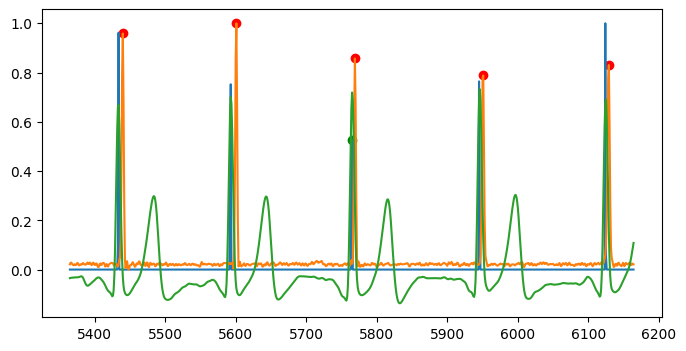

In [18]:
rank_anchor = np.argsort(losses_anchor)
i = rank_anchor[82]
i = 33
start_index = i*160
# start_index = seg_df['start'][i] - (800-(seg_df['start'][i+1]-seg_df['start'][i]))//2
R_selected_index = np.where((R_peaks > seg_df['start'][i]) & (R_peaks < seg_df['start'][i+1]))[0][0]
start_index = R_peaks[R_selected_index]-400
# ecg_length = seg_df['start'][i+1]-seg_df['start'][i]
# start_index = seg_df['start'][i] - (800-ecg_length)//2
pred_org = norm_ecg(down_sample((Anchor_pred[i]), 800))
pred = non_maximum_suppression_1d(pred_org, 0.7)
gts = down_sample(Anchor_gts[i], 800)
# gts = Anchor_gts[i]
smooth_pred = norm_ecg(smooth2nd(pred_org, 15))
selected_pred = pred_org
peaks_pred = peakutils.indexes(selected_pred, thres=0.75, min_dist=40)
peaks_gts, _ = find_peaks(norm_ecg(gts), height=0.5)
t = np.arange(0, len(pred))+ start_index
plt.figure(figsize=(8,4))
plt.plot(t,(norm_ecg(gts)))
plt.scatter(start_index+peaks_pred, (selected_pred)[peaks_pred], color='r')
rmse = np.sqrt(mean_squared_error(norm_ecg(gts), norm_ecg(selected_pred)))
# draw a point in the middle of the plot
plt.scatter(start_index+400, norm_ecg(gts)[400], color='g')
plt.plot(t, pred_org)
# plt.plot(t, selected_pred)
plt.plot(t, df['ECG'][obj_index-1][start_index:start_index+800])
plt.style.use('default')
peaks_pred+start_index, peaks_gts+start_index, peaks_pred, start_index, rmse

In [19]:
peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"
R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))  
step =160
margin = 300 # eliminate the first and last 100 points
seg_length = 800
peaks_pred_all = np.array([])
for i in range(0, len(Anchor_pred)):
    start_index = i*step
    # if i >= len(seg_df['start'])-1:
    #     break
    R_selected_index = np.where((R_peaks > seg_df['start'][i]) & (R_peaks < seg_df['start'][i+1]))[0][0]
    start_index = R_peaks[R_selected_index]-400
    # start_index = seg_df['start'][i] - (800-(seg_df['start'][i+1]-seg_df['start'][i]))//2
    pred_org = norm_ecg(down_sample((Anchor_pred[i]), seg_length))
    pred = non_maximum_suppression_1d(pred_org, 0.7)
    smooth_pred = norm_ecg(smooth2nd(pred_org, 15))
    selected_pred = pred_org
    peaks_pred = peakutils.indexes(selected_pred, thres=0.35, min_dist=40)
    # only save the peaks closest to middle
    # peaks_pred = peaks_pred[np.abs(peaks_pred-400).argmin()]
    # peaks_pred = peaks_pred[0]
    # peaks_pred = np.delete(peaks_pred, np.where(np.abs(peaks_pred-400)>margin))
    peaks_pred_all = np.append(peaks_pred_all, peaks_pred+start_index) 
peaks_pred_all = np.sort(np.delete(peaks_pred_all, np.where(peaks_pred_all<0)))
peaks_pred_all = np.sort(np.delete(peaks_pred_all, np.where(peaks_pred_all>35505)))



### Overall eval

In [20]:
def accurate_peak(R_peaks, detected, mdr_ther=30):
    offset = []
    correct_peak = np.array([])
    for peak in R_peaks:
        # if peak<3000 or peak>30000:
        #     continue
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            offset.append((detected-peak)[np.argmin(temp_error)])
            correct_peak = np.append(correct_peak, peak)
        else:
            continue
    return np.median(offset), correct_peak
def combine_close_peaks(peaks, ther):
    """
    combine the peaks that are too close to each other
    """
    distance = np.diff(peaks)
    peaks_new = np.array([])
    temp =[]
    for i in range(0, len(peaks)-1):
        temp.append(peaks[i])
        if distance[i]<ther:
            continue
        else:
            peaks_new = np.append(peaks_new, np.median(temp))
            temp = []
    return peaks_new

def miss_detect(R_peaks, detected, mdr_ther = 10):
    error_sec = 0
    missed = 0
    filtered_peaks = []
    offset = 0
    missed_peak = np.array([])
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            error_sec+=np.min(temp_error)/200
            # errors = np.append(errors, error_sec)
        else:
            missed+=1
            missed_peak = np.append(missed_peak, peak)
        # MDR = missed/len(R_peaks)
    return missed/len(R_peaks), missed_peak.astype(int)
def offset_calcu(R_peaks, detected, mdr_ther=30):
    offset = []
    missed_peak = np.array([])
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            offset.append((detected-peak)[np.argmin(temp_error)])
        else:
            missed_peak = np.append(missed_peak, peak)
    return np.median(offset), missed_peak
def metric_anchor(R_peaks, detected, mdr_ther=10):
    error_sec, missed = 0, 0
    for peak in R_peaks:
        if peak<3000 or peak>30000:
            continue
        temp_error =np.abs(detected-peak)
        if np.min(temp_error)<mdr_ther:
            error_sec+=np.min(temp_error)/200
        else:
            missed+=1
    return error_sec/(len(R_peaks)-missed/len(R_peaks))

In [21]:
peak_com = combine_close_peaks(peaks_pred_all, 30)
offset, missed_peaks = offset_calcu(R_peaks, peak_com, 30)
_, miss_peak = miss_detect(R_peaks, peak_com, 30)
error_all = metric_anchor(R_peaks, peak_com-offset, 30)

MDR = (len(missed_peaks))/len(R_peaks)
# peaks_final = peaks_final
error_all, MDR, offset, len(missed_peaks)

(0.004054826732673269, 0.0, 4.0, 0)

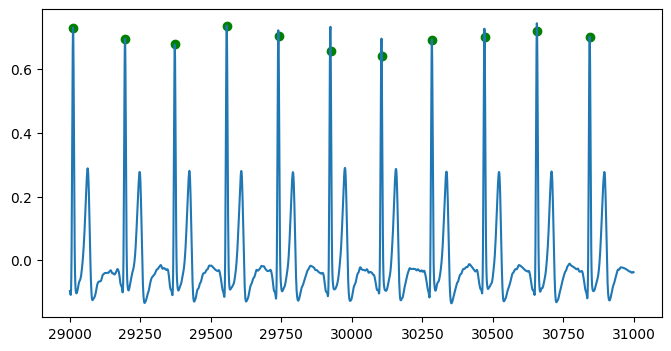

In [22]:
start = 29000
length = 2000
t = np.arange(0, length)+start
peaks_final = peaks_pred_all - offset
peaks_final_2 = peak_com- offset
peaks = peaks_final[np.where((peaks_final>=start) & (peaks_final<start+length))[0]].astype(int)
peaks_2 = peaks_final_2[np.where((peaks_final_2>=start) & (peaks_final_2<start+length))[0]].astype(int)
miss_peaks = miss_peak[np.where((miss_peak>=start) & (miss_peak<start+length))[0]].astype(int)
ecg = df.loc[obj_index-1, 'ECG'][start:start+length]
plt.figure(figsize=(8, 4))
plt.plot(t, ecg)
# plt.scatter(peaks, ecg[peaks-start], color='r')
plt.scatter(peaks_2, ecg[peaks_2-start], color='g')
plt.scatter(miss_peaks, ecg[miss_peaks-start])


In [23]:
_, peaks_final = accurate_peak(R_peaks, peaks_pred_all, 30)
ecg_final = np.zeros(35505)+0.433
seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))  
start_array, end_array = seg_df['start'].values, seg_df['end'].values
for i in range(0, len(peaks_final)):

    temp_anchor = peaks_final[i].astype(int)
    try:
        index = np.where((temp_anchor>=start_array) & (temp_anchor<end_array))[0][0]
        # print(index)
    except:
        continue
    if index >= len(ECG_pred)-1:
        continue
    temp_ecg = down_sample(ECG_pred[index], ppi_pred[index])
    pred_R_index = np.where(temp_ecg == np.max(temp_ecg))[0][0]
    ahead, behiend = pred_R_index, len(temp_ecg)-pred_R_index
    if temp_anchor-ahead<0 or temp_anchor+behiend>35505:
        continue
    # align the temp_ecg based on the pred_R_index and temp_anchor
    ecg_final[temp_anchor-ahead:temp_anchor] = temp_ecg[:ahead]
    ecg_final[temp_anchor:temp_anchor+behiend] = temp_ecg[ahead:]
for i in range(1, len(ecg_final)-30):
    if ecg_final[i]==0.433:
        for j in range(0, 30):
            if ecg_final[i+j]!=0.433:
                end = ecg_final[i+j]
                break
        # interpolate the missing value
        start = ecg_final[i-1]
        ecg_final[i:i+j] = np.linspace(start, end, j)


2024-08-09 10:15:46


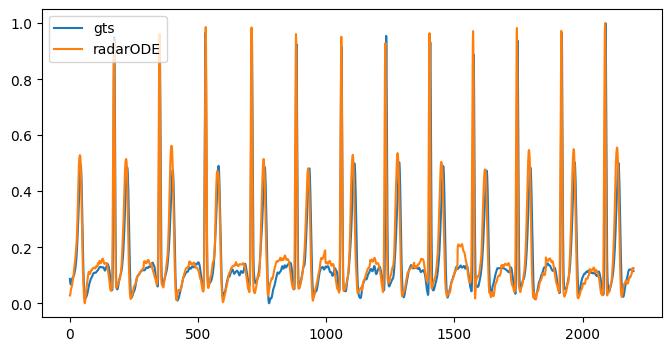

In [24]:
start = 1200
length = 2200
offset_min=0
radar_ode_root = f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_pred_perfect.npy'
# radar_ode_root = f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_ecg_pred_mmecg.npy'
radar_ode_result = np.load(radar_ode_root)
ecg_final_gts = df.loc[obj_index-1, 'ECG']
radarODE_plot = norm_ecg(radar_ode_result[start:start+length])
pred_plot = norm_ecg(ecg_final[start+offset_min:start+length+offset_min])
gts_plot = norm_ecg(df['ECG'][obj_index-1][start:start+length])
plt.figure(figsize=(8,4))
# plt.plot(pred_plot, label='pred')
plt.plot(gts_plot, label='gts')
plt.plot(radarODE_plot, label='radarODE')
plt.legend()
plt.style.use('default')
rmse = np.sqrt(mean_squared_error(pred_plot, gts_plot))
rmse_radarODE = np.sqrt(mean_squared_error(radarODE_plot, gts_plot))
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
rmse, rmse_radarODE
np.save(f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_ecg_pred_mtl.npy', ecg_final)


2024-08-09 10:15:46


0.03998350030389804

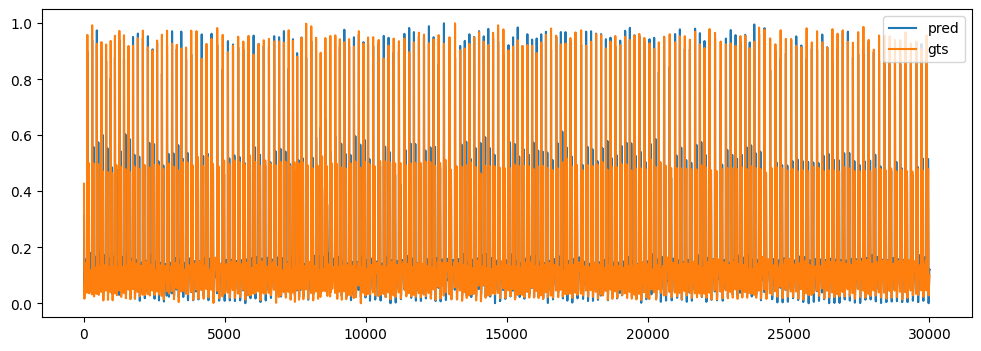

In [25]:
start = 3000
length = 30000
ecg_final_gts = df.loc[obj_index-1, 'ECG']
pred_plot = norm_ecg(ecg_final[start+offset_min:start+length+offset_min])
gts_plot = (df['ECG'][obj_index-1][start:start+length])
k = 1/(np.max(gts_plot)-np.min(gts_plot))
gts_plot = norm_ecg(gts_plot)
plt.figure(figsize=(12,4))
plt.plot(pred_plot, label='pred')
plt.plot(gts_plot, label='gts')
plt.legend()
plt.style.use('default')
rmse = mean_squared_error(norm_ecg(gts_plot)/k, norm_ecg(pred_plot)/k, squared=False)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
rmse


In [26]:
# obj_index = 73
start = 3000
length = 30000-3000
df = mat2df(obj_index)
radarODE_mtl = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_pred_mtl.npy')[start:start+length]
radarODE = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_pred_perfect.npy')[start:start+length]
MMECG = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/ecg_total_recover/{obj_index}_ecg_pred_mmecg.npy')[start:start+length]
gts = df.loc[obj_index-1, 'ECG'][start:start+length]
k = 1/(np.max(gts)-np.min(gts))
rmse_radarODE = mean_squared_error(norm_ecg(gts)/k, norm_ecg(radarODE)/k, squared=False)
rmse_radarODE_mtl = mean_squared_error(norm_ecg(gts)/k, norm_ecg(radarODE_mtl)/k, squared=False)
rmse_mmecg = mean_squared_error(norm_ecg(gts)/k, norm_ecg(MMECG)/k, squared=False)
print('MTL:', rmse_radarODE_mtl, 'radarODE:', rmse_radarODE, 'MMECG:', rmse_mmecg)


MTL: 0.04136350080804589 radarODE: 0.06020589906353464 MMECG: 0.1415376142780112


In [27]:
# obj_index = 75
np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/{obj_index}_mdr_mtl_3dB.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/1_mdr_mtl_3dB.npy'

In [ ]:
radar_ode_plot = norm_ecg(radar_ode_result[start:start+length])
rmse = mean_squared_error(norm_ecg(gts_plot)/k, norm_ecg(radar_ode_plot)/k, squared=False)
rmse

ValueError: Found input variables with inconsistent numbers of samples: [30000, 27000]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
plt_range = np.arange(3000, 30000)
seg_len =1000
step_len = 1000
rmse,pcc = [], []
min_rmse = 100
start_index = 0
gts = df.loc[obj_index-1, 'ECG']
pred = (ecg_final)
# -20 to 20 interger

# pred = radar_ode_result
for start in range(3000, 30000-seg_len, step_len):
    end = start+seg_len
    gts_plot = (gts[start:end])
    pred_plot = (pred[start+offset_min:end+offset_min])
    k = 1/(np.max(gts_plot)-np.min(gts_plot))
    rmse_temp= mean_squared_error(norm_ecg(gts_plot)/k, norm_ecg(pred_plot)/k, squared=False)
    rmse.append(rmse_temp)
print(np.mean(rmse))

0.1134354305339787


### MTL eval

In [ ]:
len(ppi_pred), len(ECG_pred)
ecg_total = np.array([])
for i in range(0, len(ECG_pred)):
    # resample the ECG_pred to corresponding PPI_pred and concatenate them
    ecg_pred = ECG_pred[i]
    ecg_pred = down_sample(ecg_pred, ppi_pred[i]+1)
    # ecg_pred = down_sample(ecg_pred, len(ecg_orgs[i]))
    ecg_total = np.append(ecg_total, ecg_pred)
# get the index from peak_index and obj_index
seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
offset = seg_df.iloc[0,0]
ecg_total = np.concatenate((np.ones(offset)*ecg_total[0], ecg_total)) if offset>0 else np.delete(ecg_total, np.arange(-offset))
if len(ecg_total) >= 35505:
    ecg_total = ecg_total[:35505]
else:
    ecg_total = np.concatenate((ecg_total, np.ones(35505-len(ecg_total))*ecg_total[-1]))

len(ecg_total)

35505

In [ ]:
# rmse and cor
rmse = np.sqrt(mean_squared_error(gts_plot, pred_plot))
cor = np.corrcoef(gts_plot, pred_plot)[0,1]
rmse, cor

(0.19736010725184575, 0.9161641955688336)

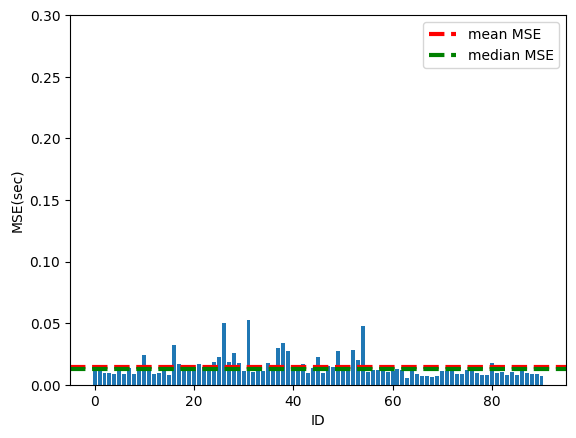

In [ ]:
kde_res_path = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/rmse_error_kde_nosample.npy'
plus_res_path = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/rmse_plus.npy'
plus_res_path = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/rmse_plus_final.npy'
# plus_res_path = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/rmse_plus_cross_vali.npy'
# plus_res_path = '/home/zhangyuanyuan/Dataset/data_MMECG/interval_pred/rmse_plus_endless_1000.npy'
ked_res, plus_res = np.load(kde_res_path), np.load(plus_res_path)

a = plus_res
# a = ked_res
fig, ax=plt.subplots()
ax.bar(np.arange(0,91),a)
ax.axhline(y=np.mean(a),c='r',label='mean MSE',linewidth=3, linestyle='--')
ax.axhline(y=np.median(a),c='g',label='median MSE',linewidth=3, linestyle='--')
# yticks = [*ax.get_yticks(), np.mean(a)]
# yticklabels = [*ax.get_yticklabels(), (np.mean(a)).round(2)]
# ax.set_yticks(yticks, labels=yticklabels)

plt.ylabel('MSE(sec)')
plt.xlabel('ID')
plt.style.use('default')
plt.ylim([0,0.3])
plt.legend()

In [ ]:
np.mean(ked_res), np.median(ked_res), np.mean(plus_res), np.median(plus_res)

(0.051737581838418784,
 0.034007697326100234,
 0.014642109182611286,
 0.01236426301887824)

In [ ]:
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2024-07-15 13:58:50
